---
# Documentation: [Managing content | Academic](https://sourcethemes.com/academic/docs/managing-content/)

title: "Modelling, Simulation and Control of Hydro-Power System - Part 2"
subtitle: "Model of the lakes"
summary: "In this series I will show the entire process of developing a model, performing simulations and the use of different control techniques for decision support in flood management systems."
authors: []
tags: ["Flood Forecasting", "Model Predictive Control"]
categories: ["Flood Management"]
date: 2021-02-10T10:01:00
lastmod: 2021-02-10T10:01:00
featured: false
draft: false

# Featured image

# To use, add an image named `featured.jpg/png` to your page's folder.

# Focal points: Smart, Center, TopLeft, Top, TopRight, Left, Right, BottomLeft, Bottom, BottomRight.

image:
 caption: "Image by <a href='https://pixabay.com/users/russmac-756431/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=929406'>Russ McElroy</a> from <a href='https://pixabay.com/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=929406'>Pixabay</a>"
 focal_point: "Smart"
 preview_only: false

# Projects (optional).

# Associate this post with one or more of your projects.

# Simply enter your project's folder or file name without extension.

# E.g. `projects = ["internal-project"]` references `content/project/deep-learning/index.md`.

# Otherwise, set `projects = []`.

projects: ["Modelling, Simulation and Control of Hydro-power system"]
---

## Overview

In the previous post of this series (see [here](/post/hydro_power/01system_description)), I showed an overview of the system we intend to model and investigate. In this post I will show how to develop a simple yet effective mathematical representation of the series of lakes in the hydro-power system.

The main use of these lakes is to work as a battery, i.e energy storage. At times when energy is at low demand, water can be pumped from the river to the lakes and stored there as potential energy. When there is a greater demand and only the level of water from the river can not provide enough energy, water can flow from the lakes to the river through turbines, using its kinetic energy to generate extra energy. Notice that this process is, in a real-world case, not 100% efficient. This means that more energy is needed to pump the water from the river to the lakes, then can be extracted by turbining from the lakes to the river. Yet, it can be a useful technique to keep the balance in energy generation, and also to redirect volume of water when its excess can cause floods downstream.

Without further delay, let's start the modeling process.

## Mathematical representation of the lakes

The water stored in the lake changes according the inflow and outflow rates. As the volume of water decreases, the level also decreases. In essence the mass conservation is the basic equation to describe the lakes:

$$
\frac{dm}{dt} = w_{in}(t) - w_{out}(t)
$$

Where $m$ is the mass of water (kg), $t$ is the time (s), $w_{in}$ is the mass inflow rate (kg/s) and $w_{in}$ is the mass outflow rate (kg/s). The above equation can be rewritten as:

$$
\frac{d(\rho hA)}{dt} = \rho q_{in}(t) - \rho q_{out}(t)
$$

Where $\rho$ is the density of water, $h$ is the water level and $A$ is the cross-section area of the lake. Since any liquid can be reasonably considered incompressible (no change of volume with pressure), the density $\rho$ can be considered constant, and thus cancelled out. The cross-section area $A$ may be constant (like a cube) or it may be a function of the water level. For better generalization. let's say $A = A(h)$, thus the final equation is:

$$
\frac{d(h A(h))}{dt} = q_{in}(t) - q_{out}(t)
$$

The above equation is an ordinary differential equation, relating the rate of change of volume ($h A(h)$) with the inlet and outlet flow rates. It can be solved using numerical integration, if all the other variables ($q_i$) are known

## Power generated/consumed by pumps and turbines

The power $p$ generated/consumed by pumps and turbines is directly proportional to the flow rate $q$ and the difference in water height $H$ upstream and downstream. The following equation describes this relation in a simple form:

$$
p = K \cdot q \cdot H
$$

Where $K$ is constant of proportionality, which can be referred as the pump/turbine coefficient (positive for turbines and negative for pumps).

## Pipes and valves

The connection between lake 1 and 2 is made through a valve. The discharge through this element can in general be modelled by a non-linear relationship with the difference in height upstream and downstream $H$ as:

$$
q = -\text{sign}(H)\cdot A \cdot \sqrt{2g|H|}
$$

Where $A$ is the duct section.


### Modular implementation of the lakes, pumps, turbines and ducts in Python

A modular approach is a useful way of implementing system behaviors, separating the organization of information and the flow of it through different components in the main simulation loop.

**OOP** is very handy for that, since it can be used to encapsulate the parameters of each instance of a class, where the class serves as a blueprint and the instances are the mathematical representations of systems.

In [39]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

GRAVITY = 9.81 # m/s2

### Generic model class

The generic model is a superclass which contains the basic behavior of a model such as lake, valve, pump, etc. The other models will inherit from this class.

In [112]:
class GenericModel:
    
    def __init__(self, name='', recorded_variables=[]):
        self.name = name
        self._log = {var: [] for var in recorded_variables}
        self._log['t'] = []
    
    def plot(self):
        t = self._log['t']
        for var in self._log:
            if var != 't':
                plt.plot(t,self._log[var] ,label=self.name + var)
        plt.legend()
    
    def generator(self,dt):
        raise NotImplementedError
    
    def log_data(self, t, **kwargs):
        self._log['t'].append(t)
        for var in kwargs:
            self._log[var].append(kwargs[var])
    

## Valve/ Pipe class

The pipe basic resemples the generic connector, since it does not generate/consume energy and it can not be opened/closed. The valve enhances the pipe by incorporating a manipulated variable $u$ which can be used to open/close the duct, restricting or not the flow rate.

In [113]:
class Pipe(GenericModel):
    def __init__(self, name='',A=1):
        recorded_variables = ['qout']
        super().__init__(name = name, recorded_variables = recorded_variables)
    
    def q(self, t, h_up, h_down):
        H = h_up - h_down
        return A*np.sqrt(GRAVITY * H)
    
    def generator(self,dt):
        t = 0
        h_up = 0
        h_down = 0
        while True:
            t, h_up, h_down = yield self.q(t, h_up, h_down)
            self.log_data(t = t, qout = self.q(t))
            t += dt

In [145]:
class Valve(GenericModel):
    def __init__(self, name='',A=1, u=lambda t: 1):
        recorded_variables = ['qout']
        super().__init__(name = name, recorded_variables = recorded_variables)
        self.u = u
    
    def q(self, t, h_up, h_down):
        H = h_up - h_down
        return self.u(t) * A*np.sqrt(GRAVITY * H)
    
    def generator(self,dt):
        t = 0
        h_up = 0
        h_down = 0
        while True:
            t, h_up, h_down = yield self.q(t, h_up, h_down)
            self.log_data(t = t, qout = self.q(t))
            t += dt

## Turbine/ Pump class

The turbine or pump is an enhacement of the valve class, because they not only can be manipulated (from 0% to 100% full power), but also consumes/ generate electricity. The difference in them is on the value of $K$, which is positive for turbines and negative for pumps.

In [115]:
class Pump_Turbine(GenericModel):
    def __init__(self, name='',A=1, K=1, u=lambda t: 1):
        recorded_variables = ['qout', 'power']
        super().__init__(name = name, recorded_variables = recorded_variables)
        self.K = 1
        self.u = u
    
    def q(self, t):
        return self.u(t)
    
    def power(self, t, h_up, h_down):
        H = h_up - h_down
        return self.K * self.q(t) * H
    
    def generator(self,dt):
        t = 0
        while True:
            t, h_up, h_down = yield self.q(t)
            self.log_data(t = t, qout = self.q(t), power = self.power(t, h_up, h_down))
            t += dt

### Lake Class

The lake class incorporates the behavior of any lake. Since the cross-section area $A$ may be constant or not ($A = A(h)$), this concept is incorporated in the class, so the Area $A$ is passed as a function of water level.

In [132]:
class Lake(GenericModel):
    
    def __init__(self, name='', A=lambda h: 1, bottom_height = 0):
        recorded_variables = ['qout', 'h']
        super().__init__(name = name, recorded_variables = recorded_variables)
        self.A = A
        self.bottom_height = bottom_height
    
    def deriv(self,h,t):
        dh = (self.qin - self.qout)/self.A(h)
        return dh
    
    
    def generator(self,dt,IC = 0):
        self.h = IC
        while True:
            t, self.qin, self.qout = yield float(self.h)
            self.h = odeint(self.deriv,self.h,[t,t+dt])[-1]
            self.log_data(t = t, qout = self.qout, h = float(self.h))
            t += dt
            
    def get_water_level(self):
        return self.h
        
    def get_absolute_water_level(self):
        return self.h + self.bottom_height
        

A careful reader will notice that we made a small trick here, to make things easier, but is not the most accurate from a mathematical perspective. The mass conservation equation was written as:

$$
\frac{dh}{dt} = \frac{q_{in}(t) - q_{out}(t)}{A(h)}
$$

Pragmatically, it is not correct to take out the term $A(h)$ from the differential term $\frac{dh}{dt}$, since the area is a function of the level. Still, it should work from a simulation perspective since we integrate the problem using small steps of time, does correcting the value of $A$ for small variations of $h$. We will see how this works with an analytical solution, so any problem will clearly arise.

## A simple test, with analytical solution

To test if our implementation is good, it is always useful to make a comparison against some analytical, exact solution. Coming back to the mass conservation:

$$
\frac{d(h A(h))}{dt} = q_{in}(t) - q_{out}(t)
$$

Let's consider a very simple lake in the form of a cube. Thus, the cross section area is constant, say equal to 1.

$$
A = 1
$$

Since $A \neq A(t)$, the equation simplifies to:

$$
\frac{dh}{dt} = q_{in}(t) - q_{out}(t)
$$

Say the outlet is regulated by a pump, with a constant flow rate of $q_{out}$, and the inflow is a sinusoidal flow with the shape, provided by a pump.

$$
q_{in}(t) = A + B\sin\frac{\pi t}{C}
$$

$$
\frac{dh}{dt} = A + B\sin\frac{\pi t}{C} - q_{out}
$$

Call $A^{*} = A - q_{out}$

$$
\frac{dh}{dt} = A^{*} + B\sin\frac{\pi t}{C}
$$

Integrate it.

$$
\int dh = \int \left(A^{*} + B\sin \left( \frac{\pi t}{C} \right)\right) dt
$$

$$
h = A^{*}t - \frac{B C}{\pi} \cos \left( \frac{\pi t}{C} \right) + \text{Const}
$$

Which gives us the general solution to this problem. Now let's fix some numerical values for simulation.
+ $q_{out} = 5$
+ $A = 5$
+ $B = 2$
+ $C=1$

$$
h = - \frac{2}{\pi} \cos \left( \pi t \right) + \text{Const}
$$

Apply initial condition $t = 0$, $h_0 = 0$

$$
\text{Const} = \frac{2}{\pi}
$$

The final analytical solution is,

$$
h = - \frac{2}{\pi} \cos \left( \pi t \right) + \frac{2}{\pi}
$$

Now let's implement the code in Python and compare the solutions


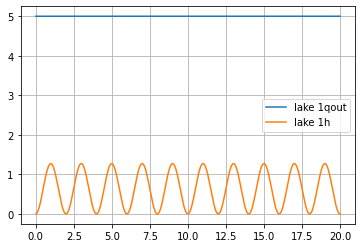

In [133]:
# basic sample time
dt = 0.01

# create and initialize lake
name_lake = 'lake 1'
Area = lambda h: 1
IC = 0
lake_obj = Lake(name = name_lake, A = Area)
lake = lake_obj.generator(dt, IC)
lake.send(None)

# create and initialize pump inlet
name_pump1 = 'pump 1'
A = 5
B = 2
C = 1
u_pump1 = lambda t: A + B *np.sin(np.pi * t/ C)
pump1_obj = Pump_Turbine(name = name_pump1, K = -1, u = u_pump1)
pump1 = pump1_obj.generator(dt)
pump1.send(None)

# create and initialize pump outlet
name_pump2 = 'pump 2'
u_pump2 = lambda t: 5 
pump2_obj = Pump_Turbine(name = name_pump2, K = -1, u = u_pump2)
pump2 = pump2_obj.generator(dt)
pump2.send(None)

for t in np.arange(0,20,dt):
    qin = pump1.send((t, 0, lake_obj.h))
    qout = pump2.send((t, lake_obj.h, 100))
    h1 = lake.send((t, qin, qout))

plt.figure()
lake_obj.plot()
plt.grid()

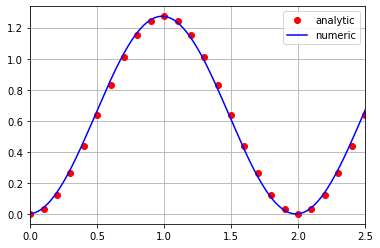

In [134]:
t = lake_obj._log['t']
qout = lake_obj._log['qout']
h = lake_obj._log['h']

h_analytic = lambda t: - 2/np.pi * np.cos(np.pi* np.asarray(t) ) + 2/np.pi

plt.figure()
plt.plot(t[::10], h_analytic(t)[::10], label = 'analytic', color = 'r', marker = 'o', linestyle="")
plt.plot(t, h, label = 'numeric', color = 'b')
plt.xlim([0.0, 2.5])
plt.grid()
plt.legend()


### Another simple test, with variable cross-section

Let's perform a similar analysis, as the one shown above, but now using a lake which has a variable cross-section area. Say that the cross-section area follows the pattern below:

$$
A(h) = E h^2
$$

Where $E$ is a constant value. Let's perform the same analytic integration process that was done above.

$$
\frac{(E h^2)dh}{dt} = A^{*} + B\sin\frac{\pi t}{C}
$$

Integrate it.

$$
\int (E h^2)dh = \int \left(A^{*} + B\sin \left( \frac{\pi t}{C} \right)\right) dt
$$

$$
h = \left[ \frac{3}{E}A^{*}t - \frac{3}{E}\frac{B C}{\pi} \cos \left( \frac{\pi t}{C} \right) + \text{Const} \right]^{\frac{1}{3}}
$$

Which gives us the general solution to this problem. Now let's fix some numerical values for simulation.
+ $q_{out} = 5$
+ $A = 5$
+ $B = 2$
+ $C=1$
+ $E=1$

$$
h = \left[ \frac{3}{E}A^{*}t - \frac{3}{E}\frac{B C}{\pi} \cos \left( \frac{\pi t}{C} \right) + \text{Const} \right]^{\frac{1}{3}}
$$

Apply initial condition $t = 0$, $h_0 = 0$

$$
0 = \left[- \frac{3}{E}\frac{B C}{\pi} + \text{Const} \right]^{\frac{1}{3}}
$$

Substituting the values here we find that,

$$
\text{Const} \approx 1.91
$$

The final analytical solution is,

$$
h = \left[ - 3\frac{2}{\pi} \cos \left(\pi t \right) + 1.91 \right]^{\frac{1}{3}}
$$

Now let's implement the code in Python and compare the solutions. For the computational approach, we have to initialize the lake with the level slight above 0, since when $h=0$, $A(h) = 0$, and since $A$ becomes a denominator in the mass conservation equation, then it would cause an indefinite solution. This naturally brings error, but we can investigate it and maybe refine the model to make it more robust for such case.



c:\users\eruss\appdata\local\programs\python\python38\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


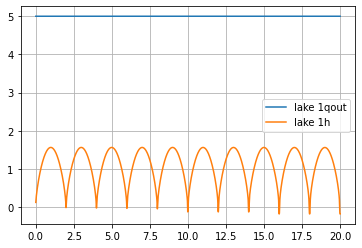

In [143]:
# basic sample time
dt = 0.01

# create and initialize lake
name_lake = 'lake 1'
Area = lambda h: h**2
IC = 1e-5
lake_obj = Lake(name = name_lake, A = Area)
lake = lake_obj.generator(dt, IC)
lake.send(None)

# create and initialize pump inlet
name_pump1 = 'pump 1'
A = 5
B = 2
C = 1
u_pump1 = lambda t: A + B *np.sin(np.pi * t/ C)
pump1_obj = Pump_Turbine(name = name_pump1, K = -1, u = u_pump1)
pump1 = pump1_obj.generator(dt)
pump1.send(None)

# create and initialize pump outlet
name_pump2 = 'pump 2'
u_pump2 = lambda t: 5
pump2_obj = Pump_Turbine(name = name_pump2, K = -1, u = u_pump2)
pump2 = pump2_obj.generator(dt)
pump2.send(None)

for t in np.arange(0,20,dt):
    qin = pump1.send((t, 0, lake_obj.h))
    qout = pump2.send((t, lake_obj.h, 100))
    h1 = lake.send((t, qin, qout))

plt.figure()
lake_obj.plot()
plt.grid()

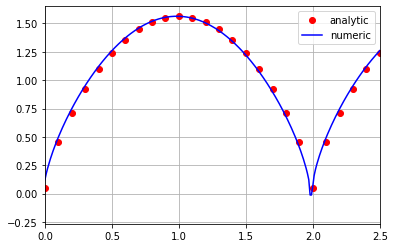

In [144]:
t = lake_obj._log['t']
qout = lake_obj._log['qout']
h = lake_obj._log['h']

t = np.arange(0,20,0.01)
h_analytic = lambda t: (-3* 2/np.pi * np.cos(np.pi* np.asarray(t) ) + 1.91)**(1/3)

plt.figure()
plt.plot(t[::10], h_analytic(t)[::10], label = 'analytic', color = 'r', marker = 'o', linestyle="")
plt.plot(t, h, label = 'numeric', color = 'b')
plt.xlim([0.0, 2.5])
plt.grid()
plt.legend()


It can be seen from these results that the trick used in the mass conservation approach does not cause much issue, and the results look quite reasonable.

In the next post, we will see how to model the reaches using the De Saint Venant Equations. I see you in the next post.